### Requirements
* EDB database with vector extended `create extension vector;`
* Feast operator

Install the repo requirment packages
```
!pip install uv 
!uv pip install -r pyproject.toml
```

# Dataset
Our reccomendation system, objected

Generate dataset for the recommendation system problem


In [1]:
!rm -rf feature_repo/data/* # TODO remove me 

In [2]:
!python3 dataset_gen.py

Users sample:
   user_id  age gender signup_date preferences
0        1   56      F  2023-09-28    Clothing
1        2   25      F  2023-04-13       Books
2        3   36      M  2023-03-29      Sports
3        4   53      M  2023-05-11      Sports
4        5   19      F  2023-10-21       Books

Items sample:
   item_id     category  subcategory  ...  new_arrival  on_sale        arrival_date
0        1        Books      Science  ...        False     True 2023-10-10 23:41:00
1        2  Electronics  Accessories  ...        False     True 2023-12-18 04:35:00
2        3        Books      Fiction  ...         True    False 2023-04-19 02:38:00
3        4  Electronics  Accessories  ...        False    False 2023-10-12 14:36:00
4        5       Sports     Footwear  ...         True    False 2023-04-18 17:29:00

[5 rows x 10 columns]

Interactions sample:
   interaction_id  user_id  item_id  ... interaction_type rating  quantity
0               1      462     2712  ...         purchase    NaN 

# Setup Feature Store

We run the `feast apply` command to register the data

In [3]:
!cd feature_repo/ ; feast apply 

/home/ikatav/Projects/rec-sys-feast-edb/.venv/lib/python3.10/site-packages/feast/feature_view.py:48: DeprecationWarning: Entity value_type will be mandatory in the next release. Please specify a value_type for entity '__dummy'.
  DUMMY_ENTITY = Entity(
No project found in the repository. Using project name feast_edb_rec_sys defined in feature_store.yaml
Applying changes for project feast_edb_rec_sys
Deploying infrastructure for user_embedding
Deploying infrastructure for user_items
Deploying infrastructure for user_features
Deploying infrastructure for item_features
Deploying infrastructure for interactions_features
Deploying infrastructure for item_embedding


In [4]:
from feast import FeatureStore
from datetime import datetime, timedelta

store = FeatureStore(repo_path="feature_repo/")

/home/ikatav/Projects/rec-sys-feast-edb/.venv/lib/python3.10/site-packages/feast/feature_view.py:48: DeprecationWarning: Entity value_type will be mandatory in the next release. Please specify a value_type for entity '__dummy'.
  DUMMY_ENTITY = Entity(


# Fatch training dataset using Feast
Defining which features, users, items, and user-item interactions to use for the training.

In [5]:
import pandas as pd
import numpy as np
# load feature services
item_service = store.get_feature_service("item_service")
user_service = store.get_feature_service("user_service")
interaction_service = store.get_feature_service("interaction_service")

num_users = 1_000
n_items = 5_000

user_ids = list(range(1, num_users+ 1))
item_ids = list(range(1, n_items+ 1))

# select which items to use for the training
item_entity_df = pd.DataFrame.from_dict(
    {
        'item_id': item_ids,
        'event_timestamp': [datetime(2025, 1, 1)] * len(item_ids) 
    }
)
# select which users to use for the training
user_entity_df = pd.DataFrame.from_dict(
    {
        'user_id': user_ids,
        'event_timestamp': [datetime(2025, 1, 1)] * len(user_ids) 
    }
)
# Select which item-user interactions to use for the training
item_user_interactions_df = pd.read_parquet('./feature_repo/data/interactions_item_user_ids.parquet')
item_user_interactions_df['event_timestamp'] = datetime(2025, 1, 1)

Retrive training data from the Feast offline store

In [6]:
# retrive datasets for training
item_df = store.get_historical_features(entity_df=item_entity_df, features=item_service).to_df()
user_df = store.get_historical_features(entity_df=user_entity_df, features=user_service).to_df()
interaction_df = store.get_historical_features(entity_df=item_user_interactions_df, features=interaction_service).to_df()

# Training

In [7]:
from models.two_tower import TwoTowerModel
from models.user_tower import UserTower
from models.item_tower import ItemTower
from models.train_two_tower import train_two_tower
dim = 64

item_encoder = ItemTower(dim)
user_encoder = UserTower(dim)
two_tower_model = TwoTowerModel(item_tower=item_encoder, user_tower=user_encoder)
train_two_tower(two_tower_model, item_df, user_df, interaction_df)

# Batch scoring
Encode the items and users vector representation

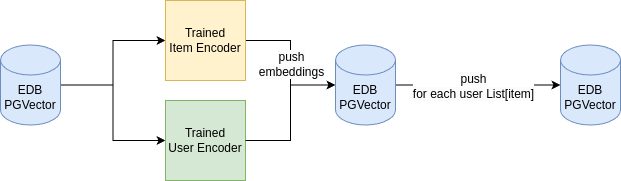

In [9]:
from feast.data_source import PushMode
from models.data_util import data_preproccess

# Create a new table to be push to the online store
item_embed_df = item_df[['item_id']].copy()
user_embed_df = user_df[['user_id']].copy()

# Encode the items and users
item_embed_df['embedding'] = item_encoder(**data_preproccess(item_df)).detach().numpy().tolist()
user_embed_df['embedding'] = user_encoder(**data_preproccess(user_df)).detach().numpy().tolist()

# Add the currnet timestamp
item_embed_df['event_timestamp'] = datetime.now()
user_embed_df['event_timestamp'] = datetime.now()

# Push the new embedding to the offline and online store
store.push('item_embed_push_source', item_embed_df, to=PushMode.ONLINE_AND_OFFLINE)
store.push('user_embed_push_source', user_embed_df, to=PushMode.ONLINE_AND_OFFLINE)

In [10]:
item_embed_df

,item_id,embedding,event_timestamp
0,167,"[0.1930214762687683, 0.5716519951820374, -2.39...",2025-03-17 11:38:53.686447
1,1003,"[-1.8535563945770264, 1.6982898712158203, -0.3...",2025-03-17 11:38:53.686447
2,4895,"[-1.8535563945770264, 1.6982898712158203, -0.3...",2025-03-17 11:38:53.686447
3,3812,"[-0.5457081198692322, 1.5239228010177612, 0.10...",2025-03-17 11:38:53.686447
4,4941,"[0.13920743763446808, -0.5535377264022827, -0....",2025-03-17 11:38:53.686447
...,...,...,...
4995,1216,"[0.1930214762687683, 0.5716519951820374, -2.39...",2025-03-17 11:38:53.686447
4996,4198,"[0.13920743763446808, -0.5535377264022827, -0....",2025-03-17 11:38:53.686447
4997,112,"[-0.8381839990615845, -0.4500148594379425, -0....",2025-03-17 11:38:53.686447
4998,2948,"[-0.5457081198692322, 1.5239228010177612, 0.10...",2025-03-17 11:38:53.686447


# Materialize
Materialization generates the latest values for each entity key in the online store and creates a time-based index to enhance retrieval speed.
The `materialize-incremental `command materializes the offline store initially and, on subsequent runs, ingests only new data and updates the store.

In [11]:
# store.materialize_incremental(datetime.now() + timedelta(days=367) , feature_views=['item_embedding'])
store.materialize_incremental(datetime.now(), feature_views=['item_embedding'])

Materializing 1 feature views to 2025-03-17 11:39:00+02:00 into the postgres online store.

item_embedding from 2020-03-18 11:39:00+02:00 to 2025-03-17 11:39:00+02:00:


/home/ikatav/Projects/rec-sys-feast-edb/.venv/lib/python3.10/site-packages/feast/entity.py:173: DeprecationWarning: Entity value_type will be mandatory in the next release. Please specify a value_type for entity 'item'.
  entity = cls(
100%|████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 17744.52it/s]


In [19]:
# store.get_online_features(f'{item_embedding_view}:item_id', item_entity_df)
embed = store.get_online_features(entity_rows=[{'item_id': 1}], features=['item_embedding:embedding']).to_df().iloc[0]['embedding']
# embed.to_df()

/home/ikatav/Projects/rec-sys-feast-edb/.venv/lib/python3.10/site-packages/feast/entity.py:173: DeprecationWarning: Entity value_type will be mandatory in the next release. Please specify a value_type for entity 'item'.
  entity = cls(


In [20]:
store.retrieve_online_documents(
    query=embed,
    top_k=64,
    feature='item_embedding:embedding'
).to_df()

,embedding,distance
0,"[0.13920744,-0.5535377,-0.53997016,-1.152985,-...",0.000000
1,"[0.13920744,-0.5535377,-0.53997016,-1.152985,-...",0.000003
2,"[0.13920744,-0.5535377,-0.53997016,-1.152985,-...",0.000009
3,"[0.13920744,-0.5535377,-0.53997016,-1.152985,-...",0.000017
4,"[0.13920744,-0.5535377,-0.53997016,-1.152985,-...",0.000037
...,...,...
59,"[0.13920744,-0.5535377,-0.53997016,-1.152985,-...",0.015759
60,"[0.13920744,-0.5535377,-0.53997016,-1.152985,-...",0.015760
61,"[0.13920744,-0.5535377,-0.53997016,-1.152985,-...",0.015763
62,"[0.13920744,-0.5535377,-0.53997016,-1.152985,-...",0.015775


In [ ]:
# Calculate user recommendations for each user
item_embedding_view = 'item_embedding'
k = 64
item_recommendation = []
for user_embed in user_embed_df['embedding']:
    item_recommendation.append(
        store.retrieve_online_documents(
            query=user_embed,
            top_k=k,
            feature=f'{item_embedding_view}:item_id'
        ).to_df()
    )
item_recommendation = [np.random.randint(0, len(user_embed_df), k).tolist()] *len(user_embed_df)
# Pushing the calculated items to the online store
user_items_df = user_embed_df[['user_id']].copy()
user_items_df['event_timestamp'] = datetime.now()
user_items_df['top_k_item_ids'] = item_recommendation

store.push('user_items_push_source', user_items_df, to=PushMode.ONLINE)

# Inferencing

## Existing User Case

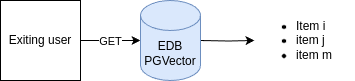

In [ ]:
existing_user_ids = np.random.randint(1, num_users + 1, 1)
suggested_items = store.get_online_features(
    features=store.get_feature_service('user_top_k_items'),
    entity_rows=[{'user_id': user_id} for user_id in existing_user_ids]
)

suggested_items.to_df()

/home/ikatav/Projects/rec-sys-feast-edb/.venv/lib/python3.10/site-packages/feast/entity.py:173: DeprecationWarning: Entity value_type will be mandatory in the next release. Please specify a value_type for entity 'item'.
  entity = cls(
/home/ikatav/Projects/rec-sys-feast-edb/.venv/lib/python3.10/site-packages/feast/entity.py:173: DeprecationWarning: Entity value_type will be mandatory in the next release. Please specify a value_type for entity 'user'.
  entity = cls(
/home/ikatav/Projects/rec-sys-feast-edb/.venv/lib/python3.10/site-packages/feast/entity.py:173: DeprecationWarning: Entity value_type will be mandatory in the next release. Please specify a value_type for entity '__dummy'.
  entity = cls(


,user_id,top_k_item_ids
0,20,"[875, 132, 944, 724, 504, 280, 511, 155, 182, ..."


## New User Case


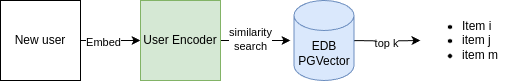

In [ ]:
from dataset_gen import generate_users
num_new_user = 1
new_users = generate_users(num_new_user, num_users + 1)
new_users_embeddings = user_encoder(**data_preproccess(new_users))
top_k_items = []
for user_embed in new_users_embeddings:
    top_k = store.retrieve_online_documents(
        query=new_users_embeddings,
        top_k=k,
        feature=f'{item_embedding_view}:embedding'
    )
    top_k_items.append(top_k)

new_users['top_k_items'] = top_k_items
new_users[['user_id', 'top_k_items']]

In [ ]:
# import sqlite3

# # Connect to the SQLite database
# connection = sqlite3.connect('feature_repo/data/online_store.db')

# # Create a cursor object to interact with the database
# cursor = connection.cursor()

# # Query to get the list of tables
# cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
# # Query to retrieve all rows from the table
# table_name = "feast_edb_rec_sys_user_embedding"
# cursor.execute(f"SELECT * FROM {table_name} LIMIT 10;")  # Fetchi
# # Fetch all results
# tables = cursor.fetchall()

# # Print the list of tables
# for table in tables:
#     print(table[0])

# # Close the connection
# connection.close()



In [ ]:
# # Calculate user recommendations for each user
# item_embedding_view = 'item_embedding'
# user_embedding_view = 'user_embedding'
# k = 64
# item_recommendation = []
# for user_embed in user_embed_df['embedding']:
#     item_recommendation.append(
#         store.retrieve_online_documents_v2(
#             query=user_embed,
#             top_k=k,
#             features=[f'{item_embedding_view}:embedding',
#                       f'{item_embedding_view}:item_id']
#         )
#     )
# # item_recommendation = [np.random.randint(0, len(user_embed_df), k).tolist()] *len(user_embed_df)
# # Pushing the calculated items to the online store
# user_items_df = user_embed_df[['user_id']].copy()
# user_items_df['event_timestamp'] = datetime.now()
# user_items_df['top_k_item_ids'] = item_recommendation

# store.push('user_items_push_source', user_items_df, to=PushMode.ONLINE)